# Sparse Sampling example 

## My Goal
To explore how under-sampling a signal can lead to strong signal reconstruction by encouraging sparsity in the fourier space representation of the signal via L1 regularisation. Compare L1 and Compressive Sampling Matching Pursuit (CoSaMP), a greedy algorithm which is similar to minimising error while penalising the L0 norm (number of non-zero entries in a vector) of the fourier space signal. 

## Some Theory
Shannon-Nyquist says that, to perfectly reconstruct a signal from a series of measurements, one must sample at twice the highest frequency present in the signal. With compressed sampling, it's possible to measure at a far lower frequency and find a sparse fourier representation of the true signal. This is done via minimising the L1-regularised error. Suppose we have a signal $x$ and we take measurements at some randomly sampled time stamps $^*$. Let's call these measurements $y = Cx$, where $C$ takes the randomly chosen timestamps to observe $x$. When we transform to fourier space, we have $x = \Phi s$ with $s$ being the SPARSE fourier representation of $x$, and $\Phi$ the fourier transform. 

$$ x = \Phi s $$
$$ y = Cx = C\Phi s $$ 

Let $\Theta = C\Phi$ so we can write $y = \Theta s$. We have $\Theta$ and $y$, so we wish to find $s$ such that $\Theta s - y$ is as small as possible. For L1-regularised compressed sampling, we impose the L1 penalty on $s$: 

$$ \underset{s}{\arg\min} \left[ ||\Theta s - y||_2^2 + \alpha ||s||_1\right] $$ 

I am not sure if it's a requirement that the fourier representation is sparse, but I think any signal can be compressed into a sparse fourier representation and the quality of the original signal is maintained somewhat (how do JPEGs work?). The relationship between input dimension (for instance a signal has $n$ evaluated steps, or an image has $l \times l = n$ pixels) $n$ and number of measurements $p$ we need to take when using this compressed sensing method is 

$$p \geq k \log_2\left(\frac{n}{k}\right)$$

I am not sure where this relationship comes from, but it's interesting that measurements $p$ scales with $\log n$. It also grows with decreasing sparsity $k$ (more non-zero vector values). Theory points to something called restricted isometric property (RIP) which must be satisfied.

$^*$ Why do we need to randomly? Let's suppose we have some regular interval of sample (every 10 seconds for some timeseries data) - we miss any feature that has periodicity in this gap. The same loss of information can occur when sampling from images (suppose we have a regular grid to sample pixels, we miss information which lies between sampled patches). I am not sure mathematically how to motivate this condition though.



## Set up  

We use a sum of two cosine waves at frequency $f_1 =97$ Hz and $f_2=777$ Hz 

$$ x = \frac{1}{2} (\cos(2\pi f_1t) + \cos(2\pi f_2t)) $$ 

as the input signal, and we try to measure this input signal at a frequency less than Shannon-Nyquist minimum frequency, and reconstruct the original signal from these measurements. According to the Shannon-Nyquist theorem, to perfectly represent this signal we need to sample at twice the highest frequency: 1554 Hz. Subbing in some numbers that we used, we have 
$$ n=1024$$
$$ k=2$$
This implies
$$ p=72$$

Note the $p$ measurements you need to take scales only logarithmically in $n$, so as we take linearly more measurements we can reconstruct exponentially larger dimensions. To obtain a sparsity $k$ the number of measurements we need to take goes like $k \log_2\left(\frac{\text{const}}{k}\right)$: going from $k=2$ to $k=4$, we go from $p=72$ to $p=128$ 



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct  # DCT used as the sparsifying basis (Psi)
from scipy.optimize import minimize
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 10})


## Function below used for the compressive sampling matching pursuit (not L1)
def cosamp(theta, u, k, epsilon=1e-10, max_iter=1000):
    """
    Return an `k`-sparse approximation of the target signal in fourier space
    Input:
        - theta, sampling matrix
        - u, noisy sample vector (observed y)
        - k, sparsity

    This function is neither strict L0 regularisation, nor L1. 
    The line where we argsort(x)[-(2*k):] means we take only 
        the largest 2*k entries in x = theta^T * v
    L1 norm is much easier to implement using sklearn 
    """
    a = np.zeros(theta.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        x = np.dot(np.transpose(theta), v)
        omega = np.argsort(x)[-(2*k):]  # indices of the 2k largest components
        omega = np.union1d(omega, a.nonzero()[0]) # grabs the indices for nonzero a and those already in omega, dropping dupes
        thetaT = theta[:, omega]
        b = np.zeros(theta.shape[1])
        # Solve Least Square
        ''' 
        solve for argmin_b [y - thetaT]
        '''
        b[omega], _, _, _ = np.linalg.lstsq(thetaT, u, rcond=None)
        
        # Prune: keep only the k largest entries to enforce sparsity
        b[np.argsort(b)[:-k]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(theta, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a


In [ ]:
## Run sparsely sampled signal reconstruction

n = 1024 # points in high resolution signal
t = np.linspace(0,1,n)
# Two-frequency cosine signal: sparsity k=2 in Fourier space
x = 0.5 * (np.cos(2 * 97 * np.pi * t) + np.cos(2 * 777 * np.pi * t)) # toy input data with two frequencies present
xt = np.fft.fft(x) # Fourier transformed signal
PSD = np.real(xt * np.conj(xt)) / n # Power spectral density

## Randomly sample signal
k = 2 # sparsity of the s vector (only k non zero elements out of n)
# Minimum number of measurements needed to satisfy the RIP condition
p = 4 * k * int(np.log2(n / k)) # number of observations (dimension of y = C @ x)
# formula because this finds minimum p that should satisfy the RIP property (restricted isometric property)
# C = np.random.randn(p, n) / np.sqrt(p) # Some Bernoulli thing... look up different C matrices

# C which is randomly selected rows of the identity matrix
selected_rows = np.random.choice(n, p, replace=False)
C = np.identity(n)[selected_rows]

# Measurements: observe y = C @ x
# shape of y is (p)
# shape of C is (p x n)
# shape of x is (n)
y = C @ x

## Solve compressed sensing problem
Psi = dct(np.identity(n)) # Build Psi basis
# Theta = Psi[C,:]       # Measure rows of Psi
# Theta combines the measurement operator C with the DCT basis, giving the sensing matrix
Theta = C @ Psi        # Measure rows of Psi 

''' 
scalers for better lasso and ridge performance ?? 
''';
# y = y / np.linalg.norm(y) # otherwise one y term can dominate the loss func
# scaler = StandardScaler(with_mean=False) # preserve sparsity, rescale Theta
# Theta = scaler.fit_transform(Theta)


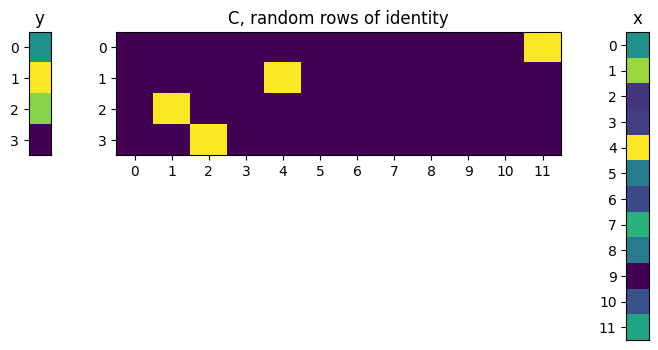

In [3]:
# Quick visualisation of C, random sampler matrix

def show_example_C_matrix():
    '''
    Just to show what C looks like, here's another example with much lower dimension 
    Plots heatmaps of C and the subsequent filtering 
    input dimension n = 12
    measurements p = 4
    '''
    n=12
    p=4
    selected_rows = np.random.choice(n, p, replace=False)
    C = np.identity(n)[selected_rows]
    x = np.random.random(n)
    y = C @ x

    # Reshape for plotting
    x_2d = x.reshape(n, 1)       # 12×1
    y_2d = y.reshape(p, 1)       # 4×1
    C_2d = C                    # 4×12

    # Create figure and adjust spacing
    fig, axs = plt.subplots(1, 3, figsize=(8, 4), width_ratios=(0.05, 1, 0.05))
    plt.subplots_adjust(wspace=0.4)

    # Plot y
    im0 = axs[0].imshow(y_2d, aspect='auto', cmap='viridis', interpolation='none')
    axs[0].set_title('y')
    axs[0].set_xticks([])
    axs[0].set_yticks(range(p))

    # Plot C
    im1 = axs[1].imshow(C_2d, aspect='auto', cmap='viridis', interpolation='none')
    axs[1].set_title('C, random rows of identity')
    axs[1].set_xticks(range(n))
    axs[1].set_yticks(range(p))

    # Plot x
    im2 = axs[2].imshow(x_2d, aspect='auto', cmap='viridis', interpolation='none')
    axs[2].set_title('x')
    axs[2].set_xticks([])
    axs[2].set_yticks(range(n))

    # Resize just the y and C plots to be shorter
    for ax in [axs[0], axs[1]]:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0 + 0.6*pos.height, pos.width, pos.height * 0.4])

    plt.show()

show_example_C_matrix()


# CoSaMP Approach

Iteratively choose the best 2 * k entries in the (k-sparse) vector s, each time updating the vector s to improve the loss (Theta * s - y) 

In [ ]:
# --- CoSaMP solution ---
s = cosamp(Theta,y,k,epsilon=1.e-10,max_iter=10) # CS via matching pursuit
# idct maps the sparse DCT coefficients back to the time domain
xrecon = idct(s) # reconstruct full signal
xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)


# Lasso L1 Norm

L1 penalty incentivises components of s to be zero: the contours of constant 1-norm $||s||_1$ in parameter space are 'spikey' and thus have higher chance of intersecting the loss landscape $\Theta s - y$ at a point where many of the s components are zero, on some kind of 'edge', especially as we get into higher dimensions (not sure why mathematically this scales well at higher dimensions, something about the ratio of space 'near an edge' to space 'not near an edge' as a function of $s$ dimension). 

We apply 

$$ \underset{s}{\arg\min} \left[ ||\Theta s - y||_2^2 + \alpha ||s||_1\right] $$ 

Or equivalently, 

$$ \underset{s}{\arg\min} ||s||_1 \text{ subject to } \Theta s - y = 0 $$

In the first setup, we have to choose value for hyperparameter $\alpha$. Too large, we penalise heavily non-zero components of $s$ and we have too sparse a vector. Too small, and we have many non-zero weights contributing noise to the $s$ vector. In the second setup, we constrain $\Theta s = y$ and the solution incidentally takes much longer to converge (10 mins versus a couple of seconds - how do I quantify this properly?). We can allow for some wiggle room (speeding up optimisation? Introducing some noise) by constraining that $\Theta s - y \lt \epsilon$ instead of $\Theta s - y = 0$.

#### Scaling 

I found scaling to be of high importance in this method. We take the final reconstructed signal and scale up by the norm of the input signal.



In [ ]:
# %%time  # un-comment to find out how long cell takes to run
# --- Lasso solution ---
# Method 1: minimise 2-norm of (Theta*s - y) while penalising 1-norm of s
alpha = 0.0001  # regularization strength; smaller = less sparsity, larger = more sparsity
lasso = Lasso(alpha=alpha, fit_intercept=False, max_iter=10000)
lasso.fit(Theta, y)

s_lasso = lasso.coef_
x_lasso_recon_unscaled = idct(s_lasso, norm='ortho')

# Lasso output amplitude is dampened by the regularisation, so rescale to match original signal norm
scale = np.linalg.norm(x) / np.linalg.norm(x_lasso_recon_unscaled)
x_lasso_recon = x_lasso_recon_unscaled * scale
xtrecon_lasso = np.fft.fft(x_lasso_recon,n) # computes the (fast) discrete fourier transform
PSDrecon_lasso = np.real(xtrecon_lasso * np.conj(xtrecon_lasso))/n # Power spectrum (how much power in each freq)

In [6]:
# %%time  # un-comment to find out how long cell takes to run
''' 
This cell takes a while to run
'''

# --- Lasso solution ---
# Method 2: minimise 1-norm of s under constraint  Theta @ x - y = 0

def L1_norm(x):
    return np.linalg.norm(x,ord=1)

''' uncomment below to run ''';
# constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
# x0 = np.linalg.pinv(Theta) @ y 
# res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
# s_lasso_method_2 = res.xs

#### Investigating Lasso in some more depth

How sparse actually is $s$ generated by lasso? 

In [ ]:
zero_percent = {}

# Test a range of thresholds to see how sparse the Lasso solution actually is
thresholds = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6]  # Choose based on scale of your problem
total_coeffs = len(s_lasso)

for threshold in thresholds:
    num_small = np.count_nonzero(np.abs(s_lasso) < threshold)
    zero_percent[threshold] = 100 * num_small / total_coeffs  # percentage

# Sort dictionary by threshold (just in case)
sorted_items = sorted(zero_percent.items())
thresholds, percents = zip(*sorted_items)

# Plot
plt.figure(figsize=(6, 4))
plt.bar([str(t) for t in thresholds], percents, color='skyblue')
plt.xlabel('Threshold')
plt.ylabel('Percentage of Coefficients < Threshold (%)')
plt.title('Lasso Coefficient Sparsity vs. Threshold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

'''
lasso s vector thresholded to allow for around k non-zero entries
looking at data in chart looks like to make a sparsity of ballpark the 
sparsity we aim for we need to set the threshold quite high
choose threshold to be 1e-2
''';
# s_lasso[np.abs(s_lasso) < 1e-2] = 0
# np.count_nonzero(s_lasso == 0)

'''
-- Lasso code from textbook -- 
## L1-Minimization using SciPy

This method minimises |s|_1 subject to constraint that Theta @ x - y = 0
whereas the above method minimises [Theta @ x - y + alpha |s|_1]
''';
# def L1_norm(x):
#     return np.linalg.norm(x,ord=1)

# constr = ({'type': 'eq', 'fun': lambda x:  Theta @ x - y})
# x0 = np.linalg.pinv(Theta) @ y 
# res = minimize(L1_norm, x0, method='SLSQP',constraints=constr)
# s_lasso = res.x


# Ridge L2 Norm

$$ \underset{s}{\arg\min} \left[ ||\Theta s - y||_2^2 + \alpha ||s||_2\right] $$ 

Just for fun, we try replacing the Lasso with Ridge regularisation. We would not expect this to produce a sparse $s$ vector because Ridge penalises the 2-norm of the $s$ vector, not the 1-norm. Although this shrinks the magnitude of the components, in the parameter space of s, the contours of constant 2-norm |s| are 'round' (circle in 2d, sphere in 3d, etc) which intersect the error function $\Theta * s - y$ generally away from the axes (non-zero values for all s components). The issue is lots of noise to the signal reconstruction given we are looking for a sparse $s$ vector.

In [ ]:
# %%time  # un-comment to find out how long cell takes to run

# --- Ridge solution --- 
# Ridge (L2) does not promote sparsity, so reconstruction quality is expected to be worse than Lasso
alpha = 0.0001  # regularization strength; tweak this!
ridge = Ridge(alpha=alpha, fit_intercept=False, max_iter=10000)
ridge.fit(Theta, y)
s_ridge = ridge.coef_
x_ridge_recon_unscaled = idct(s_ridge, norm='ortho')

# rescale the ridge output with norm of x
scale = np.linalg.norm(x) / np.linalg.norm(x_ridge_recon_unscaled)
x_ridge_recon = x_ridge_recon_unscaled * scale
xtrecon_ridge = np.fft.fft(x_ridge_recon,n) # computes the (fast) discrete fourier transform
PSDrecon_ridge = np.real(xtrecon_ridge * np.conj(xtrecon_ridge))/n # Power spectrum (how much power in each freq)


# No Regularisation, Just Undersampling

What about if we apply no regularising and just minimise the error 

$$ \underset{s}{\arg\min} ||\Theta s - y||_2^2 $$ 

while sampling at $\lt$ Shannon Nyquist Frequency. We can see this by setting $\alpha=0$ for Ridge / Lasso, as this gets rid of the penalty altogether.



# Plot 

Some visualisation of the $\Theta$ matrix, $\Phi$ basis, and $C$ matrix (although hard to see non-zero pixels here). We plot $s$ for each type of solution, and we can see that for the CoSaMP and Lasso methods, a large proportion of the $s$ values are very close to zero. In the CoSaMP case, all but $k$ are set to zero by construction. In the Lasso case, many are near zero (see threshold graph above). For Ridge / Least Squares, the values in $s$ are more spread out with fewer 'outliers' in the Ridge case (as these get heavily penalised).

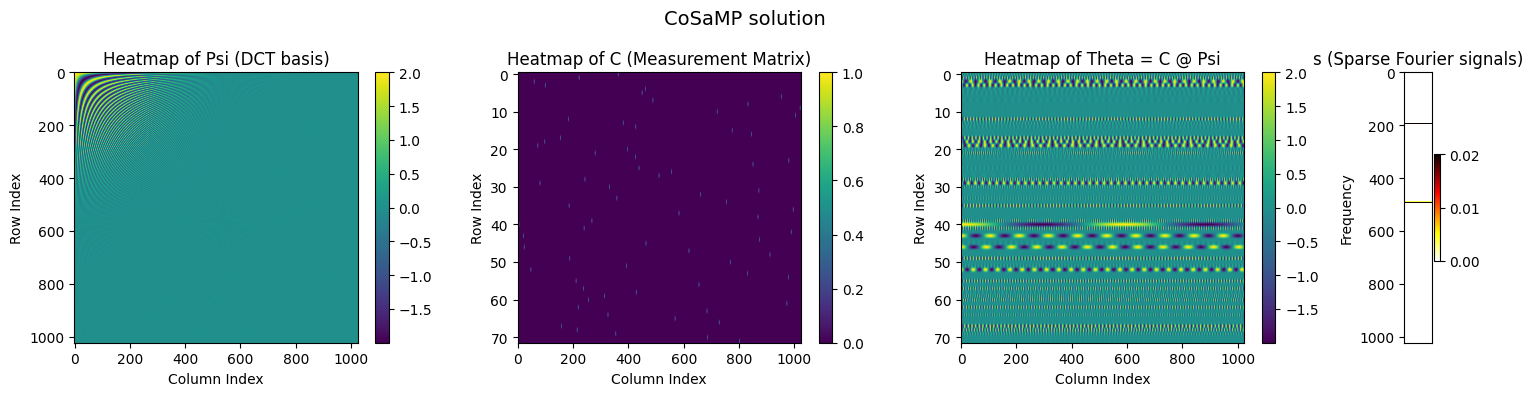

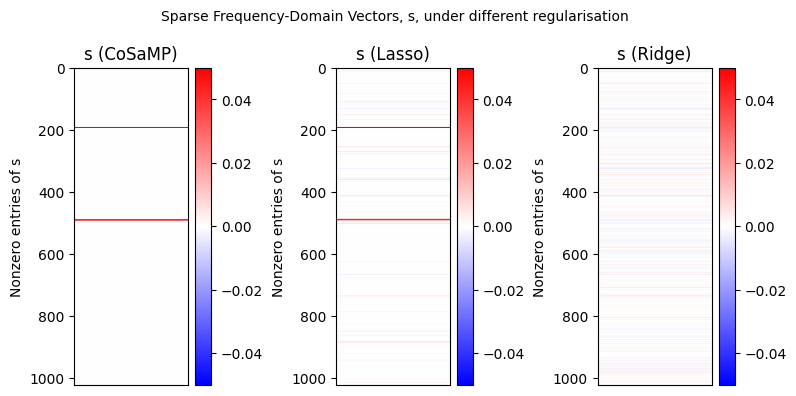

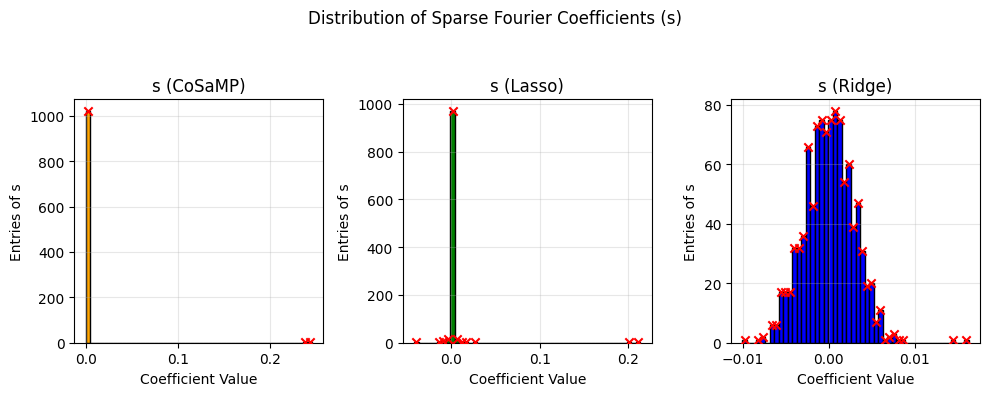

In [9]:
# plot fourier vectors and transform matrices

# Reshape s for visualization
s_image = s.reshape(-1, 1)
s_lasso_image = s_lasso.reshape(-1, 1)
s_ridge_image = s_ridge.reshape(-1, 1)


fig, axs = plt.subplots(
    1, 4,
    figsize=(15, 4),
    gridspec_kw={'width_ratios': [1, 1, 1, 0.1]}  # Last one is slim
)
fig.suptitle('CoSaMP solution', fontsize=14)

im0 = axs[0].imshow(Psi, cmap='viridis', aspect='auto')
axs[0].set_title('Heatmap of Psi (DCT basis)')
axs[0].set_xlabel('Column Index')
axs[0].set_ylabel('Row Index')
fig.colorbar(im0, ax=axs[0], orientation='vertical')

im1 = axs[1].imshow(C, cmap='viridis', aspect='auto')
axs[1].set_title('Heatmap of C (Measurement Matrix)')
axs[1].set_xlabel('Column Index')
axs[1].set_ylabel('Row Index')
fig.colorbar(im1, ax=axs[1], orientation='vertical')

im2 = axs[2].imshow(Theta, cmap='viridis', aspect='auto')
axs[2].set_title('Heatmap of Theta = C @ Psi')
axs[2].set_xlabel('Column Index')
axs[2].set_ylabel('Row Index')
fig.colorbar(im2, ax=axs[2], orientation='vertical')

im3 = axs[3].imshow(s_image, cmap='hot_r', aspect='auto', vmax=0.02)
axs[3].set_title('s (Sparse Fourier signals)')
axs[3].set_ylabel('Frequency')
axs[3].set_xticks([])
fig.colorbar(im3, ax=axs[3])

plt.tight_layout()
plt.show()

fig, axs = plt.subplots(
    1, 3,
    figsize=(8, 4),
    gridspec_kw={'width_ratios': [1, 1, 1]} 
)
fig.suptitle('Sparse Frequency-Domain Vectors, s, under different regularisation', fontsize=10)

im0 = axs[0].imshow(s_image, cmap='bwr', aspect='auto', vmin=-0.05, vmax=0.05)
axs[0].set_title('s (CoSaMP)')
axs[0].set_ylabel('Nonzero entries of s')
axs[0].set_xticks([])
fig.colorbar(im0, ax=axs[0], orientation='vertical')

im1 = axs[1].imshow(s_lasso_image, cmap='bwr', aspect='auto', vmin=-0.05, vmax=0.05)
axs[1].set_title('s (Lasso)')
axs[1].set_ylabel('Nonzero entries of s')
axs[1].set_xticks([])
fig.colorbar(im1, ax=axs[1], orientation='vertical')

im2 = axs[2].imshow(s_ridge_image, cmap='bwr', aspect='auto', vmin=-0.05, vmax=0.05)
axs[2].set_title('s (Ridge)')
axs[2].set_ylabel('Nonzero entries of s')
axs[2].set_xticks([])
fig.colorbar(im2, ax=axs[2], orientation='vertical')


plt.tight_layout()
plt.show()


fig, axs = plt.subplots(
    1, 3,
    figsize=(10, 4),
    gridspec_kw={'width_ratios': [1, 1, 1]}
)
fig.suptitle('Distribution of Sparse Fourier Coefficients (s)', fontsize=12)

# Histogram of CoSaMP
counts, bins, _ = axs[0].hist(s, bins=50, color='orange', edgecolor='black')
axs[0].set_title('s (CoSaMP)')
axs[0].set_xlabel('Coefficient Value')
axs[0].set_ylabel('Entries of s')
axs[0].grid(True, alpha=0.3)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
axs[0].scatter(bin_centers[counts > 0], counts[counts > 0], marker='x', color='red', zorder=3)

# Histogram of Lasso
counts, bins, _ = axs[1].hist(s_lasso, bins=50, color='green', edgecolor='black')
axs[1].set_title('s (Lasso)')
axs[1].set_xlabel('Coefficient Value')
axs[1].set_ylabel('Entries of s')
axs[1].grid(True, alpha=0.3)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
axs[1].scatter(bin_centers[counts > 0], counts[counts > 0], marker='x', color='red', zorder=3)

# Histogram of Ridge
counts, bins, _ = axs[2].hist(s_ridge, bins=50, color='blue', edgecolor='black')
axs[2].set_title('s (Ridge)')
axs[2].set_xlabel('Coefficient Value')
axs[2].set_ylabel('Entries of s')
axs[2].grid(True, alpha=0.3)
bin_centers = 0.5 * (bins[1:] + bins[:-1])
axs[2].scatter(bin_centers[counts > 0], counts[counts > 0], marker='x', color='red', zorder=3)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave room for supertitle
plt.show()



# Signal Reconstruction

Plot of the reconstructed signal on top of the original true signal, with points of sampling shown by the red crosses. Plot of power spectra (fourier transform of reconstructed signal, squared). The power spectra should show peaks at 97Hz and 777Hz. I  am not sure why we have more peaks at around 250 and 750... is this some kind of aliasing? 

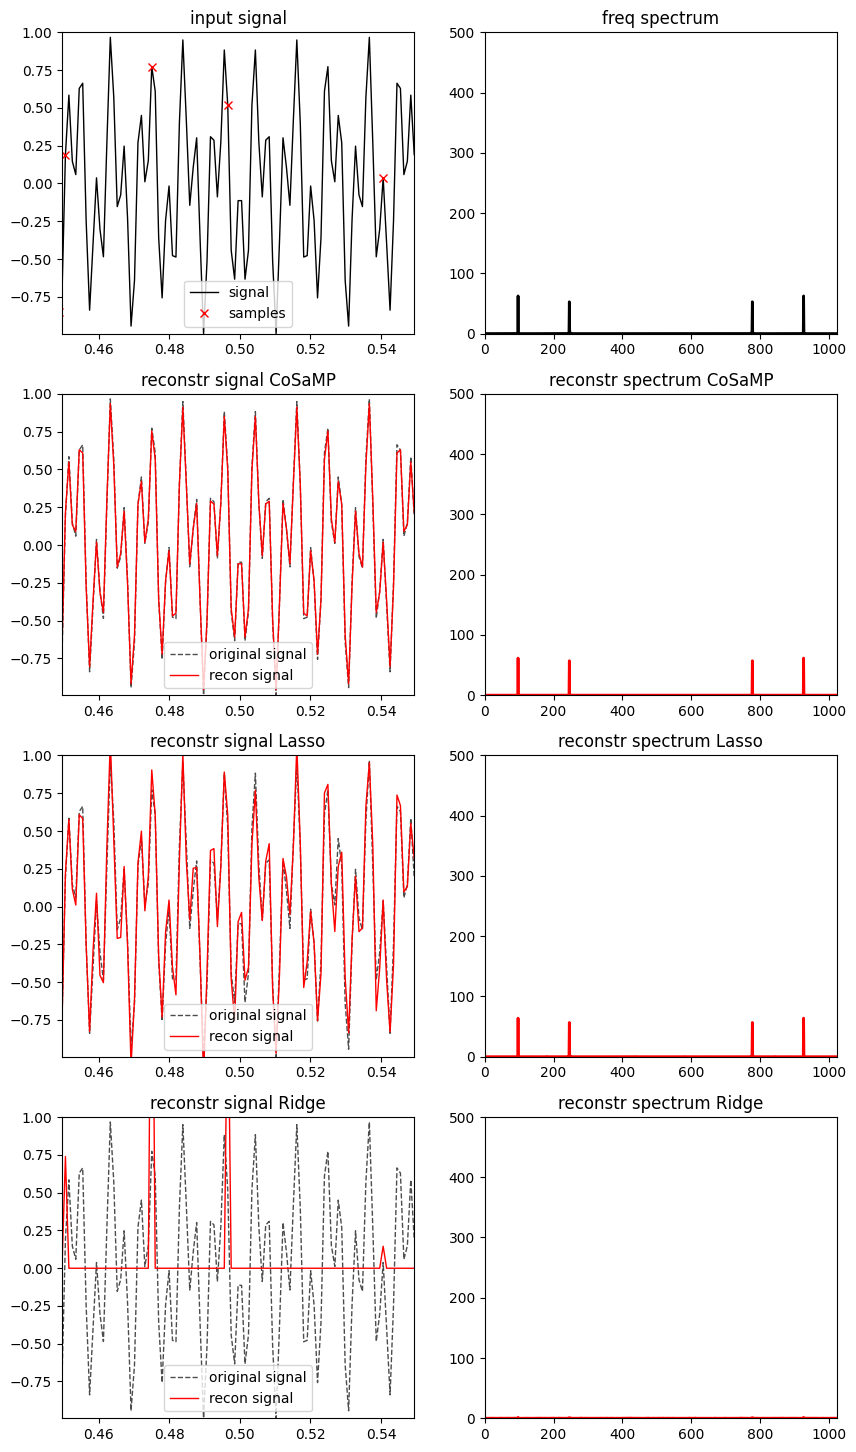

In [10]:
def window(x, start_portion=0.45, end_portion=0.55):
    start_ix = int(np.floor(start_portion*len(x)))
    end_ix = int(np.floor(end_portion*len(x)))
    return x[start_ix:end_ix]

t_window = window(t)
freq = np.arange(n)
sampled_x = C @ x
sampled_t = C @ t
ymin = x.min()
ymax = x.max()

fig,axs = plt.subplots(4,2, figsize=(10, 18))
axs = axs.reshape(-1)

axs[1].set_title("freq spectrum")
axs[1].plot(freq,PSD,color='k',linewidth=2)
axs[1].set_xlim(0, 1024)
axs[1].set_ylim(0, 500)

axs[0].set_title("input signal")
axs[0].plot(t_window,window(x),color='k',linewidth=1, label='signal')
axs[0].plot(sampled_t,sampled_x,color='r',marker='x',linewidth=0,ms=6,mew=1, label='samples')
axs[0].set_xlim(min(t_window), max(t_window))
axs[0].set_ylim(ymin, ymax)
axs[0].legend()

axs[2].set_title("reconstr signal CoSaMP")
axs[2].plot(t_window,window(x),color='k',linewidth=1, alpha=0.7, ls='--', label='original signal')
axs[2].plot(t_window,window(xrecon),color='r',linewidth=1, label='recon signal')
axs[2].set_xlim(min(t_window), max(t_window))
axs[2].set_ylim(ymin, ymax)
axs[2].legend()


axs[3].set_title("reconstr spectrum CoSaMP")
axs[3].plot(freq,np.real(PSDrecon),color='r',linewidth=2)
axs[3].set_xlim(0, 1024)
axs[3].set_ylim(0, 500)


# -- Lasso -- 


axs[4].set_title("reconstr signal Lasso")
axs[4].plot(t_window,window(x),color='k',linewidth=1, alpha=0.7, ls='--', label='original signal')
axs[4].plot(t_window,window(x_lasso_recon),color='r',linewidth=1, label='recon signal')
axs[4].set_xlim(min(t_window), max(t_window))
axs[4].set_ylim(ymin, ymax)
axs[4].legend()

axs[5].set_title("reconstr spectrum Lasso")
axs[5].plot(freq,np.real(PSDrecon_lasso),color='r',linewidth=2)
axs[5].set_xlim(0, 1024)
axs[5].set_ylim(0, 500)


# -- Ridge -- 

axs[6].set_title("reconstr signal Ridge")
axs[6].plot(t_window,window(x),color='k',linewidth=1, alpha=0.7, ls='--', label='original signal')
axs[6].plot(t_window,window(x_ridge_recon),color='r',linewidth=1, label='recon signal')
axs[6].set_xlim(min(t_window), max(t_window))
axs[6].set_ylim(ymin, ymax)
axs[6].legend()


x_ridge_recon = idct(100 * s_ridge, norm='ortho')
xtrecon_ridge = np.fft.fft(x_ridge_recon,n) # computes the (fast) discrete fourier transform
PSDrecon_ridge = np.real(xtrecon_ridge * np.conj(xtrecon_ridge))/n # Power spectrum (how much power in each freq)

axs[7].set_title("reconstr spectrum Ridge")
axs[7].plot(freq,np.real(PSDrecon_ridge),color='r',linewidth=2)
axs[7].set_xlim(0, 1024)
axs[7].set_ylim(0, 500)

plt.show()


# My questions 

- why power spectra showing more than expected peaks 
- mathematical difference between the two Lasso methods above 
- why does method 2 take so much longer than method 1? How can I try method 2 with $\epsilon$ error bound rather than strict zero
- get my head around why I need to rescale the Lasso $s$ 
- not so clear on how the fourier transform works (by the discrete $\Phi$ matrix)
- maths of restrictive isometric property and where minimum for $p$ comes in 


# Where is Compressed Sampling useful? 

Medical Imaging
- Fewer samples, same quality of image, less time under scan, less discomfort, cheaper, higher throughput

Digital Cameras
- Fewer measurements, same quality of image, cheaper than high resolution sensors 

Wireless Communication 
- Only a few frequencies dominate in communication channels, accurate reception with fewer signals, improves spectral efficiency

There are more with similar ideas to above, where we wish to take fewer measurements and achieve same quality output